# Aprendizaje No Supervisado

### Motivación:


- Nuestro retail desea tener una segmentación de usuarios.


- Una posibilidad es tener en cuenta el GMV (https://en.wikipedia.org/wiki/Gross_merchandise_volume) generado por cada usuario e identificar aquellos "power users" en base a alguna regla (e.g. aquellos usuarios que superan el GMV medio + 2 * desvio estandar).


- Un caso de uso posible es, una vez identificadas las características de usuarios que son "power users", inferir que nuevos usuarios que poseen características similares lo van a ser y enfocar campañas de retención a esos usuarios.

### Consignas:

- Dado el conjunto de usuarios que realizaron compras en nuestro retail, generar una segmentación de los mismos indicando que caracteristicas comunes presenta cada segmento.


- La idea es utilizar alguna técnica de clustering para segmentar usuarios en base a su representación vectorial.


- Tener en cuenta qué features utilizar para dicha tarea.


- Yellowbrick: https://www.scikit-yb.org/en/latest/api/cluster/index.html es una libreria interesante para visualizar métricas propias de Clustering: Silhouette, Elbow y la Distancia Intercluster.


- Brindar conclusiones y con qué estrategias se podría seguir trabajando esta problemática en base a lo investigado.


### Notas:

- El enfoque es libre. Se puede intentar utilizar el GMV acumulado de usuario como se plantea en la sección de motivación como ir por otro enfoque.


- Es recomendable obtener soluciones de clustering con diferente número de clusters, especialmente números altos, para observar las subdivisiones de las clases, y qué clases se confunden más.


- Es recomendable, si tiene sentido en el dataset, probar diferentes subconjuntos de características (esto no tiene sentido si hay pocas características en el dataset).


- Se puede intentar proyectar el dataset a algún embedding (por ejemplo, PCA) y comparar qué sucede en ese espacio en comparación con lo que sucede en el espacio original.


- Es muy recomendable integrar indicadores de mala calidad como por ejemplo "hay un cluster muy grande y el resto son muy chicos", lo cual indica que en el espacio no se distinguen bien grupos separados y hay que usar otro espacio.

In [1]:
#librerías necesarias:

# Data handling
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import seaborn
import matplotlib as plt


# Clustering
from sklearn.cluster import KMeans, DBSCAN
from sklearn import preprocessing
from sklearn.metrics import silhouette_score

# Dimensionality reduction
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Visualization
import seaborn as sns
#import plotly.express as px
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
from matplotlib import animation

%matplotlib inline 

## Carga de datos

In [2]:
data = pd.read_csv('retail_sales.csv').dropna()
data[:5]

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,152.00
6,1000004,P00184942,M,46-50,7,B,2,1,1,8.0,17.0,192.15
13,1000005,P00145042,M,26-35,20,A,1,1,1,2.0,5.0,156.65
14,1000006,P00231342,F,51-55,9,A,1,0,5,8.0,14.0,53.78
16,1000006,P0096642,F,51-55,9,A,1,0,2,3.0,4.0,130.55


In [3]:
data.dtypes

User_ID                         int64
Product_ID                     object
Gender                         object
Age                            object
Occupation                      int64
City_Category                  object
Stay_In_Current_City_Years     object
Marital_Status                  int64
Product_Category_1              int64
Product_Category_2            float64
Product_Category_3            float64
Purchase                      float64
dtype: object

## Clientes con mayores compras

Previo a encodear las variable vamos a identificar aquellos compradores mas importantes para detectar las variables mas importantes que pueden motivar descubrir nuevos clientes importantes.

In [4]:
data = pd.DataFrame(data)

In [5]:
data_1 = data.groupby(['User_ID'])['Purchase'].sum().reset_index()
data_1.sort_values('Purchase', ascending=False)[:10]

,User_ID,Purchase
4151,1004277,27505.04
4319,1004448,24862.16
2819,1002909,23914.31
1876,1001941,22494.62
1625,1001680,22287.61
533,1000550,21164.94
2939,1003032,21016.29
416,1000424,20981.87
532,1000549,20497.15
3905,1004021,20431.09


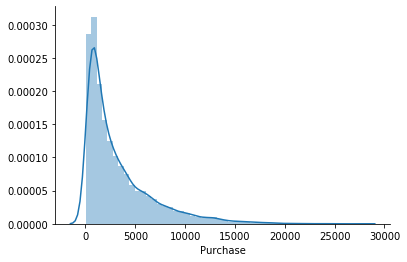

In [6]:
seaborn.distplot(data_1['Purchase'])
seaborn.despine()

In [7]:
gmv = data_1['Purchase'].mean()+2*data_1['Purchase'].std()

In [8]:
power_users = data_1[data_1['Purchase'] >= gmv]
print('Se cuenta con una cantidad de', len(power_users), 'POWER-USERS')

Se cuenta con una cantidad de 332 POWER-USERS


## Partición del DataSet Original

Del dataset original creamos 2 sub-dataset que uno va a contener los usuarios con más compras y otro el resto de los usuarios.

Dataset 1 que contiene los power users.

In [9]:
data_pu = data[data['User_ID'].isin(power_users['User_ID'])]
len(data_pu)

38326

Dataset 2 que contiene los registros del resto de los usuarios

In [10]:
data_npu = data[~data['User_ID'].isin(power_users['User_ID'])]
len(data_npu)

125952

## Análisis descriptivo Power-Users

Se consideran solo las caracteristicas relevantes de cada usuario. No se considera si un mismo usuario compro mas de un producto ni las caracteristicas de los mismo (se suprimen los features `Product ID`, `Product_Category_1`, `Product_Category_2`, `Product_Category_3`)

In [11]:
data_pu_1 = data_pu.groupby(['User_ID', 'Gender', 'Age', 'Occupation', 'City_Category', 'Stay_In_Current_City_Years', 'Marital_Status'])['Purchase'].sum().reset_index()
data_pu_1.sort_values('Purchase', ascending=False)[:5]

,User_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Purchase
250,1004277,M,36-45,16,A,0,0,27505.04
266,1004448,M,26-35,14,A,0,0,24862.16
160,1002909,M,26-35,7,A,1,0,23914.31
122,1001941,M,36-45,17,A,1,0,22494.62
104,1001680,M,26-35,20,A,3,1,22287.61


Se analizan la distribucion de los principales compradores por ocupación, ciudad y edad

Catplot con la distribución de las compras

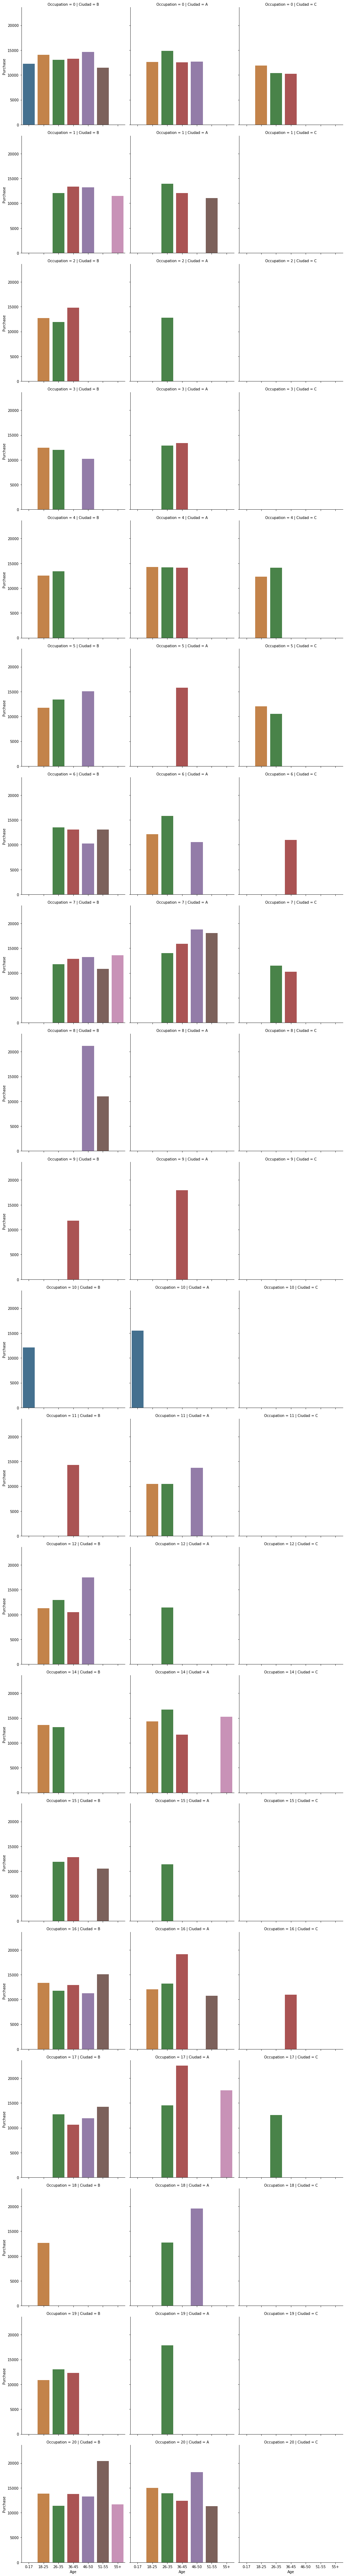

In [12]:
catplot_data = data_pu_1
catplot_data['Ciudad'] = catplot_data['City_Category']

order = ['0-17', '18-25', '26-35', '36-45', '46-50', '51-55', '55+']
g = seaborn.catplot(
    data=catplot_data, x='Age', y='Purchase', order=order,
    row='Occupation', col='Ciudad',
    kind='bar',
    saturation=.5,
    ci=None, aspect=.9)

Catplot de la cantidad de grandes compradores por features considerados

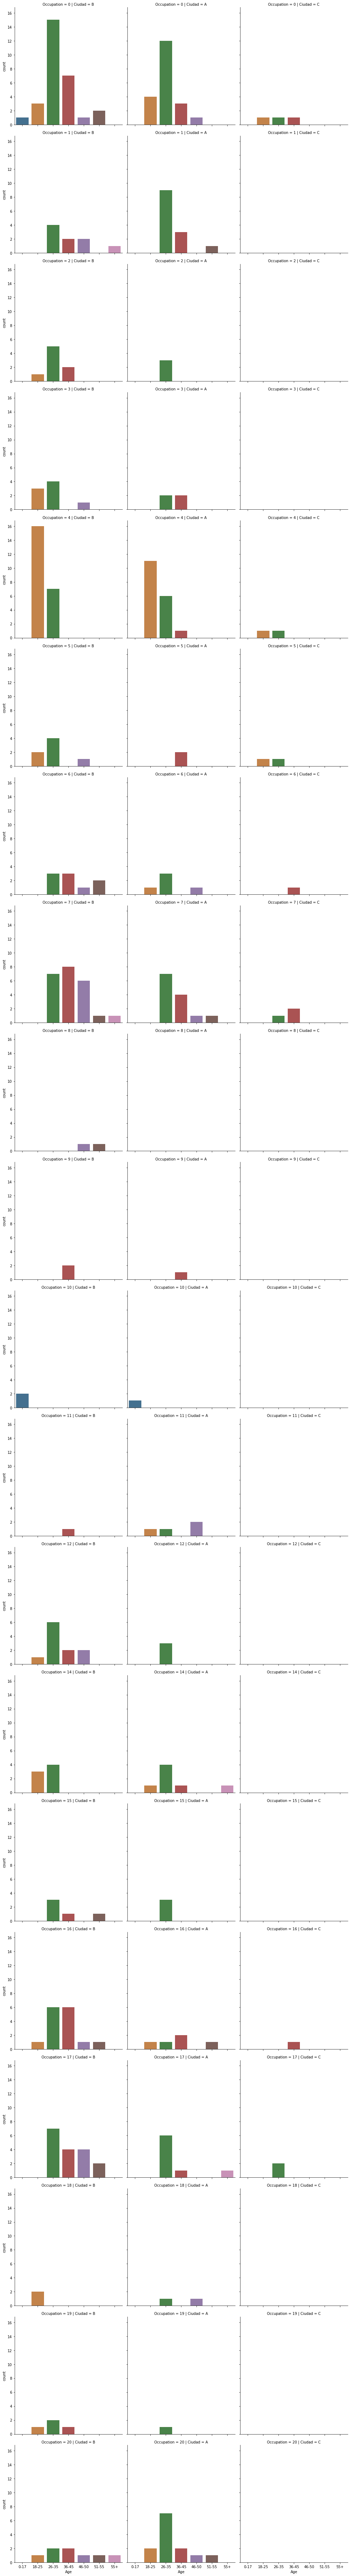

In [13]:
catplot_data = data_pu_1
catplot_data['Ciudad'] = catplot_data['City_Category']

order = ['0-17', '18-25', '26-35', '36-45', '46-50', '51-55', '55+']
g = seaborn.catplot(
    data=catplot_data, x='Age', order=order,
    row='Occupation', col='Ciudad',
    kind='count',
    saturation=.5,
    ci=None, aspect=.9)

In [14]:
data_pu_2 = pd.DataFrame(data_pu_1, columns=['User_ID', 'Age', 'Occupation', 'City_Category', 'Purchase'])

In [15]:
pd.set_option('display.max_columns', None)

In [16]:
data_pu_2_1 = pd.pivot_table(data_pu_2, values='User_ID', index=['City_Category','Age'], columns=['Occupation'], aggfunc=pd.Series.nunique, dropna=True, margins= True, fill_value='-')
data_pu_2_1

Occupation            0   1   2   3   4   5   6   7  8  9 10 11  12  14 15  \
City_Category Age                                                            
A             0-17    -   -   -   -   -   -   -   -  -  -  1  -   -   -  -   
              18-25   4   -   -   -  11   -   1   -  -  -  -  1   -   1  -   
              26-35  12   9   3   2   6   -   3   7  -  -  -  1   3   4  3   
              36-45   3   3   -   2   1   2   -   4  -  1  -  -   -   1  -   
              46-50   1   -   -   -   -   -   1   1  -  -  -  2   -   -  -   
              51-55   -   1   -   -   -   -   -   1  -  -  -  -   -   -  -   
              55+     -   -   -   -   -   -   -   -  -  -  -  -   -   1  -   
B             0-17    1   -   -   -   -   -   -   -  -  -  2  -   -   -  -   
              18-25   3   -   1   3  16   2   -   -  -  -  -  -   1   3  -   
              26-35  15   4   5   4   7   4   3   7  -  -  -  -   6   4  3   
              36-45   7   2   2   -   -   -   3   8  -  2  -  1   2   -  1   
              46-50   1   2   -   1   -   1   1   6  1  -  -  -   2   -  -   
              51-55   2   -   -   -   -   -   2   1  1  -  -  -   -   -  1   
              55+     -   1   -   -   -   -   -   1  -  -  -  -   -   -  -   
C             18-25   1   -   -   -   1   1   -   -  -  -  -  -   -   -  -   
              26-35   1   -   -   -   1   1   -   1  -  -  -  -   -   -  -   
              36-45   1   -   -   -   -   -   1   2  -  -  -  -   -   -  -   
All                  52  22  11  12  43  11  15  39  2  3  3  5  14  14  8   

Occupation           16  17 18 19  20  All  
City_Category Age                           
A             0-17    -   -  -  -   -    1  
              18-25   1   -  -  -   2   21  
              26-35   1   6  1  1   7   69  
              36-45   2   1  -  -   2   22  
              46-50   -   -  1  -   1    7  
              51-55   1   -  -  -   1    4  
              55+     -   1  -  -   -    2  
B             0-17    -   -  -  -   -    3  
              18-25   1   -  2  1   1   34  
              26-35   6   7  -  2   2   79  
              36-45   6   4  -  1   2   41  
              46-50   1   4  -  -   1   21  
              51-55   1   2  -  -   1   11  
              55+     -   -  -  -   1    3  
C             18-25   -   -  -  -   -    3  
              26-35   -   2  -  -   -    6  
              36-45   1   -  -  -   -    5  
All                  21  27  4  5  21  332

Tal como puede observarse en el CatPlot como en la tabla, la mayor cantidad de Power Users se ubican en la ciudad B y se concentran en el rango etario 26-35.

### Encode de las variables

In [17]:
X= data_pu_2.drop(["User_ID"],axis=1)
len(X)

332

In [18]:
X['Occupation'] = X['Occupation'].astype('str')

X = pd.get_dummies(X)


X["Purchase"]=preprocessing.minmax_scale((X["Purchase"]))

In [19]:
X.describe()

,Purchase,Age_0-17,Age_18-25,Age_26-35,Age_36-45,Age_46-50,Age_51-55,Age_55+,Occupation_0,Occupation_1,Occupation_10,Occupation_11,Occupation_12,Occupation_14,Occupation_15,Occupation_16,Occupation_17,Occupation_18,Occupation_19,Occupation_2,Occupation_20,Occupation_3,Occupation_4,Occupation_5,Occupation_6,Occupation_7,Occupation_8,Occupation_9,City_Category_A,City_Category_B,City_Category_C
count,332.000000,332.000000,332.000000,332.000000,332.000000,332.000000,332.000000,332.000000,332.000000,332.000000,332.000000,332.000000,332.000000,332.000000,332.000000,332.000000,332.000000,332.000000,332.000000,332.000000,332.000000,332.000000,332.000000,332.000000,332.000000,332.000000,332.000000,332.000000,332.000000,332.000000,332.000000
mean,0.178520,0.012048,0.174699,0.463855,0.204819,0.084337,0.045181,0.015060,0.156627,0.066265,0.009036,0.015060,0.042169,0.042169,0.024096,0.063253,0.081325,0.012048,0.015060,0.033133,0.063253,0.036145,0.129518,0.033133,0.045181,0.117470,0.006024,0.009036,0.379518,0.578313,0.042169
std,0.163841,0.109266,0.380282,0.499445,0.404179,0.278313,0.208014,0.121976,0.363997,0.249120,0.094771,0.121976,0.201277,0.201277,0.153580,0.243785,0.273747,0.109266,0.121976,0.179253,0.243785,0.186932,0.336279,0.179253,0.208014,0.322465,0.077498,0.094771,0.486000,0.494574,0.201277
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.053177,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.139143,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,0.250916,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [20]:
X.shape

(332, 31)

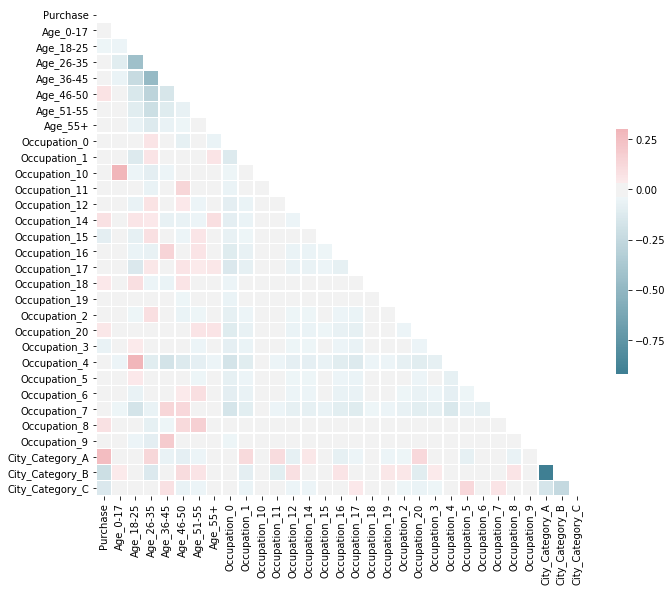

In [21]:
def plot_corr(X):
    corr = X.corr()
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    f, ax = plt.subplots(figsize=(11, 9))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

plot_corr(X)

### Cluster

#### K-Medias

In [22]:
kmedias3=KMeans(n_clusters=3).fit(X)
print(kmedias3)
print('Suma de los cuadrados de las distancias al clusters / Inertia: ', kmedias3.inertia_)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)
Suma de los cuadrados de las distancias al clusters / Inertia:  504.1305341308022


Rastreo de número de cluster del 2 al 10

Text(0.5, 1.0, 'Inertia of k-Means versus number of clusters')

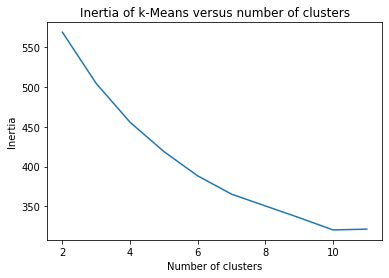

In [23]:
scores = [KMeans(n_clusters=i+2).fit(X).inertia_ for i in range(10)]
plt.plot(np.arange(2, 12), scores)
plt.xlabel('Number of clusters')
plt.ylabel("Inertia")
plt.title("Inertia of k-Means versus number of clusters")

Modelo con 8 clusters

In [24]:
kmeans = KMeans(n_clusters=8)
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

#### K-Medias normalizado

Text(0.5, 1.0, 'Inertia of Cosine k-Means versus number of clusters')

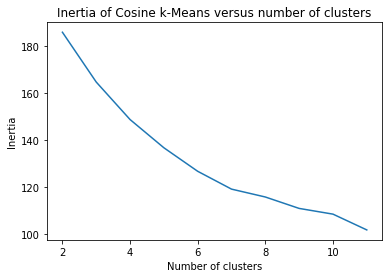

In [25]:
normalized_vectors = preprocessing.normalize(X)
scores = [KMeans(n_clusters=i+2).fit(normalized_vectors).inertia_ for i in range(10)]
plt.plot(np.arange(2, 12), scores)
plt.xlabel('Number of clusters')
plt.ylabel("Inertia")
plt.title("Inertia of Cosine k-Means versus number of clusters")

In [26]:
normalized_kmeans = KMeans(n_clusters=7)
normalized_kmeans.fit(normalized_vectors)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=7, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

#### Modelo D-BScan

In [27]:
min_samples = X.shape[1]+1
dbscan = DBSCAN(eps=3.5, min_samples=min_samples).fit(X)

#### Evaluación modelos

In [28]:
from collections import Counter
print('cantidad de datos por cluster con kmedias: ',Counter(kmeans.labels_))
print('cantidad de datos por cluster en dist. coseno: ',Counter(normalized_kmeans.labels_))
print('cantidad de datos por cluster de DBSCAN: ',Counter(dbscan.labels_))

cantidad de datos por cluster con kmedias:  Counter({5: 72, 3: 66, 2: 46, 6: 37, 0: 36, 4: 35, 7: 21, 1: 19})
cantidad de datos por cluster en dist. coseno:  Counter({3: 85, 2: 69, 0: 46, 5: 38, 4: 37, 6: 36, 1: 21})
cantidad de datos por cluster de DBSCAN:  Counter({0: 332})


In [29]:
print('kmeans: {}'.format(silhouette_score(X, kmeans.labels_, metric='euclidean')))
print('Cosine kmeans: {}'.format(silhouette_score(normalized_vectors, normalized_kmeans.labels_, metric='cosine')))

kmeans: 0.23568629250024828
Cosine kmeans: 0.40975973993891157


Eliminamos el DBScan por que solo nos detecto 1 cluster

In [30]:
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(X))
df_scaled.columns = X.columns
df_scaled['kmedias'] = kmeans.labels_
df_scaled['kmed_cos'] = normalized_kmeans.labels_
df_scaled.head()

,Purchase,Age_0-17,Age_18-25,Age_26-35,Age_36-45,Age_46-50,Age_51-55,Age_55+,Occupation_0,Occupation_1,Occupation_10,Occupation_11,Occupation_12,Occupation_14,Occupation_15,Occupation_16,Occupation_17,Occupation_18,Occupation_19,Occupation_2,Occupation_20,Occupation_3,Occupation_4,Occupation_5,Occupation_6,Occupation_7,Occupation_8,Occupation_9,City_Category_A,City_Category_B,City_Category_C,kmedias,kmed_cos
0,0.054238,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,6,4
1,0.139089,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3,3
2,0.508377,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,3
3,0.132553,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3,3
4,0.210482,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,5,2


#### Aplicación Modelo K-medias normalizado

In [31]:
df_mean = df_scaled.loc[df_scaled.kmed_cos!=-1, :].groupby('kmed_cos').mean().reset_index()
df_mean

,kmed_cos,Purchase,Age_0-17,Age_18-25,Age_26-35,Age_36-45,Age_46-50,Age_51-55,Age_55+,Occupation_0,Occupation_1,Occupation_10,Occupation_11,Occupation_12,Occupation_14,Occupation_15,Occupation_16,Occupation_17,Occupation_18,Occupation_19,Occupation_2,Occupation_20,Occupation_3,Occupation_4,Occupation_5,Occupation_6,Occupation_7,Occupation_8,Occupation_9,City_Category_A,City_Category_B,City_Category_C,kmedias
0,0,0.134926,0.000000,0.0,0.0,1.000000,0.000000,0.000000,0.000000,0.173913,0.043478,0.000000,0.021739,0.043478,0.000000,0.021739,0.152174,0.086957,0.000000,0.021739,0.043478,0.043478,0.000000,0.000000,0.000000,0.086957,0.217391,0.000000,0.043478,0.0,0.891304,0.108696,2.000000
1,1,0.200857,0.000000,1.0,0.0,0.000000,0.000000,0.000000,0.000000,0.190476,0.000000,0.000000,0.047619,0.000000,0.047619,0.000000,0.047619,0.000000,0.000000,0.000000,0.000000,0.095238,0.000000,0.523810,0.000000,0.047619,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,7.000000
2,2,0.225919,0.000000,0.0,1.0,0.000000,0.000000,0.000000,0.000000,0.173913,0.130435,0.000000,0.014493,0.043478,0.057971,0.043478,0.014493,0.086957,0.014493,0.014493,0.043478,0.101449,0.028986,0.086957,0.000000,0.043478,0.101449,0.000000,0.000000,1.0,0.000000,0.000000,5.000000
3,3,0.137760,0.000000,0.0,1.0,0.000000,0.000000,0.000000,0.000000,0.188235,0.047059,0.000000,0.000000,0.070588,0.047059,0.035294,0.070588,0.105882,0.000000,0.023529,0.058824,0.023529,0.047059,0.094118,0.058824,0.035294,0.094118,0.000000,0.000000,0.0,0.929412,0.070588,2.694118
4,4,0.143397,0.000000,1.0,0.0,0.000000,0.000000,0.000000,0.000000,0.108108,0.000000,0.000000,0.000000,0.027027,0.081081,0.000000,0.027027,0.000000,0.054054,0.027027,0.027027,0.027027,0.081081,0.459459,0.081081,0.000000,0.000000,0.000000,0.000000,0.0,0.918919,0.081081,6.000000
5,5,0.176684,0.078947,0.0,0.0,0.000000,0.552632,0.289474,0.078947,0.105263,0.078947,0.052632,0.000000,0.052632,0.000000,0.026316,0.052632,0.157895,0.000000,0.000000,0.000000,0.078947,0.026316,0.000000,0.026316,0.078947,0.210526,0.052632,0.000000,0.0,1.000000,0.000000,3.763158
6,6,0.264625,0.027778,0.0,0.0,0.611111,0.194444,0.111111,0.055556,0.111111,0.111111,0.027778,0.055556,0.000000,0.055556,0.000000,0.083333,0.055556,0.027778,0.000000,0.000000,0.111111,0.055556,0.027778,0.055556,0.027778,0.166667,0.000000,0.027778,1.0,0.000000,0.000000,0.000000


Utilizamos Random Forest para detectar cuales son los features mas relevantes y que mayor peso tienen sobre los power users

In [32]:
from sklearn.ensemble import RandomForestClassifier
y = normalized_kmeans.labels_
X = X
clf = RandomForestClassifier(n_estimators=100).fit(X, y)
selected_columns = list(pd.DataFrame(np.array([clf.feature_importances_, X.columns]).T, columns=['Importance', 'Feature'])
           .sort_values("Importance", ascending=False)
           .head(7)
           .Feature
           .values)

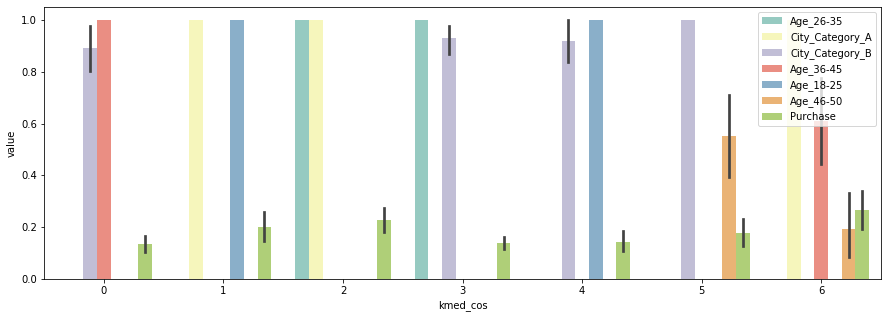

In [33]:
# Plot data
tidy = df_scaled[selected_columns+['kmed_cos']].melt(id_vars='kmed_cos')
fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(x='kmed_cos', y='value', hue='variable', data=tidy, palette='Set3')
plt.legend(loc='upper right')

In [34]:
imp_features = pd.unique(tidy['variable'])

#### PCA sobre features mas relevantes

In [35]:
def prepare_pca(n_components, data):
    names = ['x', 'y', 'z']
    matrix = PCA(n_components=n_components).fit_transform(data)
    df_matrix = pd.DataFrame(matrix)
    df_matrix.rename({i:names[i] for i in range(n_components)}, axis=1, inplace=True)
        
    return df_matrix

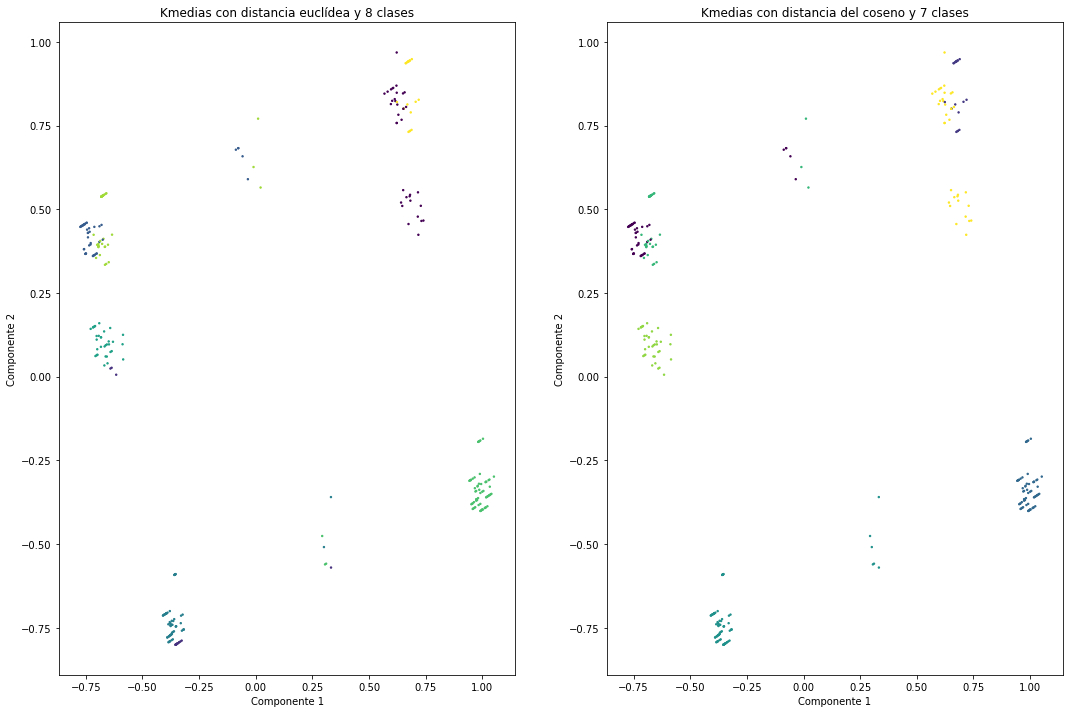

In [36]:
pca_df = prepare_pca(3, X)

fig, axs = plt.subplots(nrows=1, ncols=2, sharex=True)
fig.set_figheight(12)
fig.set_figwidth(18)
axs[0].scatter(x=pca_df.x, y=pca_df.y,c=kmeans.labels_, label=kmeans.labels_, s=2)
axs[0].set_title('Kmedias con distancia euclídea y 8 clases')
axs[0].set_xlabel('Componente 1')
axs[0].set_ylabel('Componente 2')

axs[1].scatter(x=pca_df.x, y=pca_df.y,c=normalized_kmeans.labels_, label=normalized_kmeans.labels_, s=2)
axs[1].set_title('Kmedias con distancia del coseno y 7 clases')
axs[1].set_xlabel('Componente 1')
axs[1].set_ylabel('Componente 2')



plt.show()

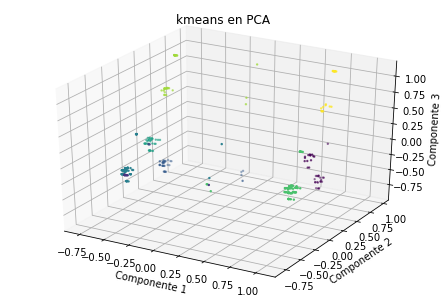

In [37]:
from mpl_toolkits.mplot3d import Axes3D

target=kmeans.labels_
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(pca_df.x, pca_df.y, pca_df.z,c=target,label=target, s=2)
ax.set_xlabel('Componente 1')
ax.set_ylabel('Componente 2')
ax.set_zlabel('Componente 3')
plt.title('kmeans en PCA')
plt.show()

## Conclusiones

En el presente práctico se trabajó con los principales consumidores del DataSet (denominados `Power Users`) y se analizaron las principales carácterísticas de los mismos: `Edad`, `Ciudad` y `Ocupación`.

Del análisis de Clusters, surge que se pueden condormar 7 grupos heterogéneos entre si, pero homogéneos hacía el interior de cada uno.

A su vez, se destacó de los `Power Users` las carácterísticas mas relevantes y que más explican la importancia de los mismos:
* `Age 18-25`
* `Age 26-35`
* `Age 36-45`
* `Age 46-50`
* `City A`
* `City B`

De esta forma, es posible confeccionar pautas direccionadas con el DataSet relagado que contiene potenciales `Power Users`, considerando las principales características detectadas que definen esta categoría de usuarios.